In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as npimg
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import random
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.applications import ResNet50
from keras.callbacks import EarlyStopping

# Obtain the data

In [3]:
datadir = 'sim_data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000079
1,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000082
2,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000078
3,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000078
4,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000080


In [4]:
# removing prefix path from image path

def remove_prefix(path):
    return path.split('\\')[-1]

data['center'] = data['center'].apply(remove_prefix)
data['left'] = data['left'].apply(remove_prefix)
data['right'] = data['right'].apply(remove_prefix)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


# EDA

In [5]:
nbins = 25 #taking odd number because 0 have to be in the middle
hist, bins = np.histogram(data['steering'], nbins) #hist variable provides hsit values for each bin (total 31) and bins variable provides edges of bins
# bins ranging from -1 to 1

In [6]:
# if there will be less datapoints for left or right, data will be imbalanced therefore we need to balance the data by having maximum datapoints for straight driving
# but as there is not zero in the bin but we need absolute 0 to know how many values we have of 0 becuase we are expecting to drive straight most of the time, therefore--

center = (bins[:-1] + bins[1:]) * 0.5 #center the bins to 0 #as the value will be nearly doubled, we are dividing by 2
center 

array([-0.96, -0.88, -0.8 , -0.72, -0.64, -0.56, -0.48, -0.4 , -0.32,
       -0.24, -0.16, -0.08,  0.  ,  0.08,  0.16,  0.24,  0.32,  0.4 ,
        0.48,  0.56,  0.64,  0.72,  0.8 ,  0.88,  0.96])

<BarContainer object of 25 artists>

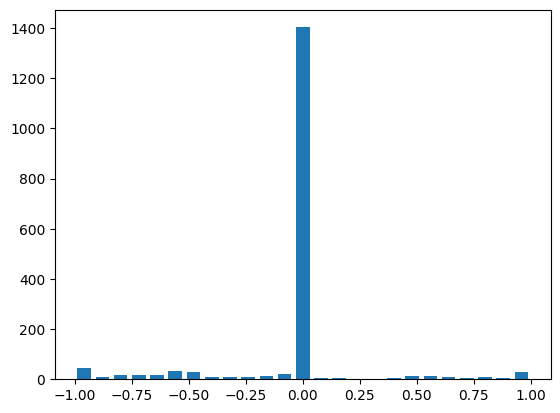

In [7]:
plt.bar(center, hist, width=0.06)

From above graph we can see that most of the time car is driving straight, which is what we needed
But as the center values are simply too much, too balance the dataset, we will cut the graph by setting samples_per_bin to 1000

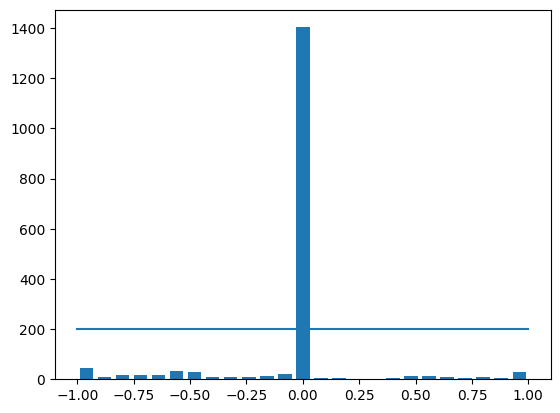

In [8]:
samples_per_bin = 200
plt.bar(center, hist, width=0.06)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin)) #plotting a line from (-1,200) to (1,200) to show the number of samples per bin

In [9]:
# remove the extra data points from the bins
removeIndexList = []
for j in range(nbins):
    list_ = [] #this list wlil contain each datapoint in each bin
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_) #we are shuffling becuase if we take first 200 values, it will be biased as the order of data is not random so only small values will be taken
    list_ = list_[samples_per_bin:]
    removeIndexList.extend(list_)
    
data.drop(data.index[removeIndexList], inplace=True)
print('Removed images: ', len(removeIndexList))
print('Remaining images: ', len(data))


Removed images:  1203
Remaining images:  540


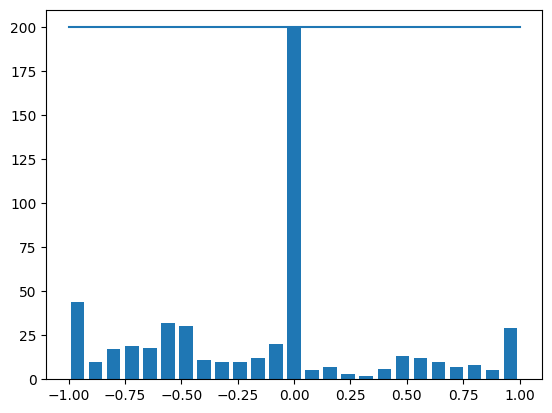

In [10]:
# after removing the part of the graph where the number of samples are more than 200

hist, _ = np.histogram(data['steering'], nbins)
plt.bar(center, hist, width=0.06)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin)) 
plt.show()

In [11]:
# load all the images as well as the steering wheel angle values in a numpy array

def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
image_paths , steerings

(array(['sim_data/IMG/center_2019_07_22_20_38_15_669.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_15_802.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_15_937.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_17_547.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_17_823.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_18_495.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_18_633.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_18_893.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_19_514.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_20_082.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_20_405.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_20_682.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_22_035.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_22_568.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_23_142.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_24_777.jpg',
        'sim_data/IMG/center_2019_07_22_20_38_24_980.jpg

Training Samples: 432
Valid Samples: 108


Text(0.5, 1.0, 'Validation set')

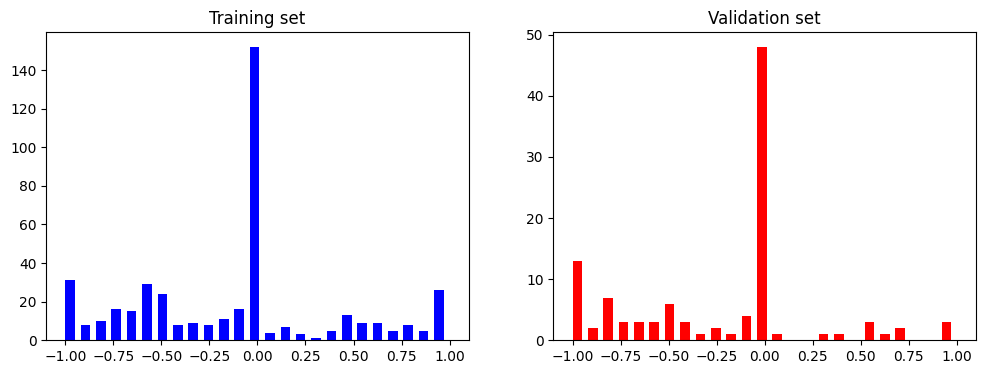

In [12]:
# # train validation split using 80-20 rule 
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

# plotting a histogram for training and validation set
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=nbins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=nbins, width=0.05, color='red')
axes[1].set_title('Validation set')

# Image Preprocessing

Text(0.5, 1.0, 'Preprocessed Image')

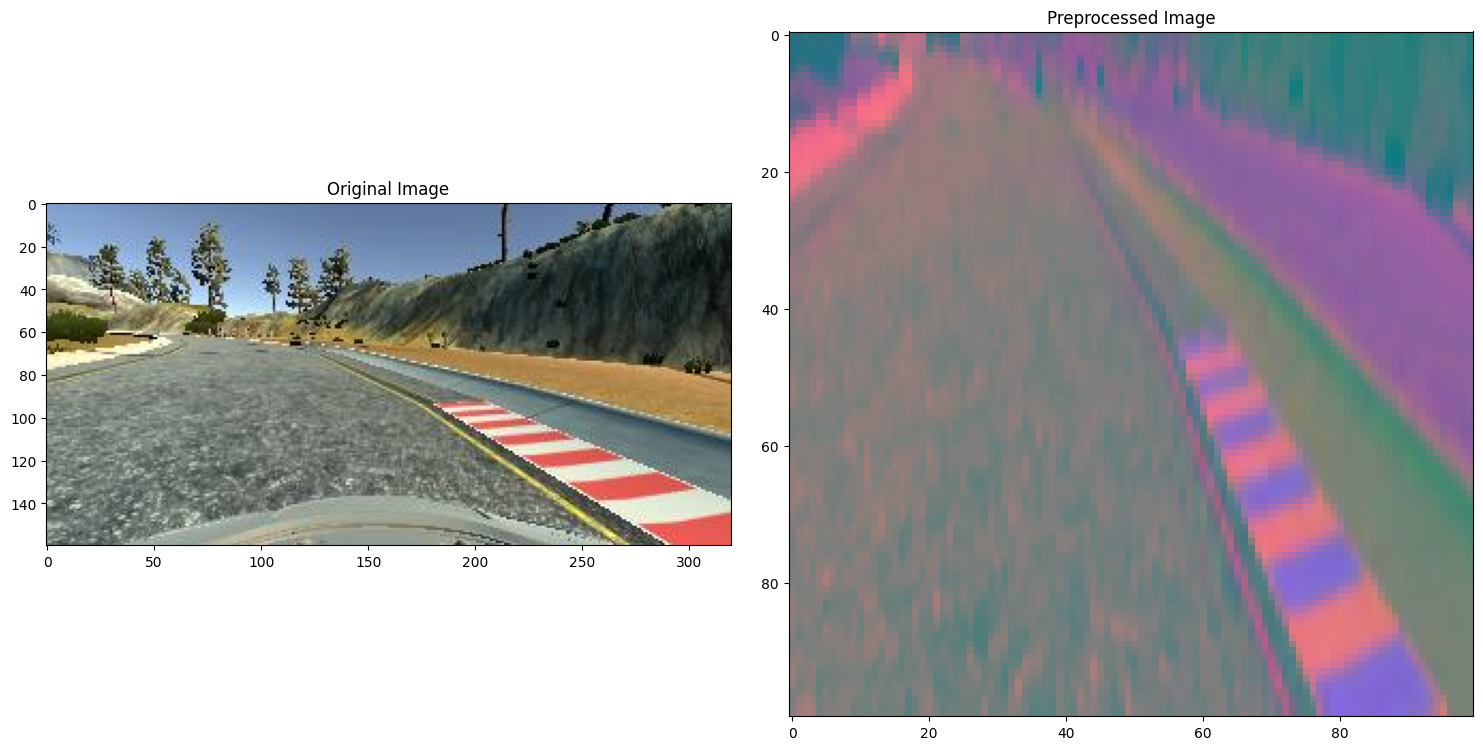

In [13]:
def img_preprocess(img):
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img

# plotting the before and after images of preprocessing to compare and visualize the difference
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [14]:
# preprocessing all the images

X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

# Training

In [15]:
# using resnet50 model for transfer learning
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# freezing some layers from the last to fine tune with our and use the resnet just as a feature extractor
for layer in resnet.layers[:-4]:
    layer.trainable = False
    
for layer in resnet.layers:
    print(layer, layer.trainable)

94765736/94765736 [==============================] - 30s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x7fd07c1c1a90> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fd080f366d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd080f36b20> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd080f36880> False
<keras.src.layers.core.activation.Activation object at 0x7fd080f36f70> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fd080fa2670> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fd080e945e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd080ef46d0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd080ef4160> False
<keras.src.layers.core.activation.Activation object at 0x7fd080e852e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd080e85f10> False
<ker

In [23]:
# fine tuning the resnet model with our model

def nvidia_model(bn=False):
    model = Sequential()
    model.add(resnet)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    if bn:
        model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='elu'))
    if bn:
        model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    if bn:
        model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout_4 (Dropout)         (None, 4, 4, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               3276900   
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dropout_6 (Dropout)         (None, 50)               

In [17]:
#model 1 without batch normalization and early stopping

history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

Epoch 1/25
4/4 [==============================] - 9s 2s/step - loss: 15.4440 - accuracy: 0.1991 - val_loss: 0.6184 - val_accuracy: 0.4444
Epoch 2/25
4/4 [==============================] - 6s 2s/step - loss: 15.5627 - accuracy: 0.1852 - val_loss: 0.6682 - val_accuracy: 0.4444
Epoch 3/25
4/4 [==============================] - 6s 2s/step - loss: 9.6175 - accuracy: 0.1829 - val_loss: 0.3903 - val_accuracy: 0.4444
Epoch 4/25
4/4 [==============================] - 6s 2s/step - loss: 4.5583 - accuracy: 0.2292 - val_loss: 0.2945 - val_accuracy: 0.4444
Epoch 5/25
4/4 [==============================] - 6s 2s/step - loss: 2.8372 - accuracy: 0.2222 - val_loss: 0.2590 - val_accuracy: 0.4444
Epoch 6/25
4/4 [==============================] - 7s 2s/step - loss: 2.5696 - accuracy: 0.2384 - val_loss: 0.2770 - val_accuracy: 0.4444
Epoch 7/25
4/4 [==============================] - 7s 2s/step - loss: 2.1004 - accuracy: 0.2523 - val_loss: 0.5031 - val_accuracy: 0.4444
Epoch 8/25
4/4 [=======================

Text(0.5, 0, 'Epoch')

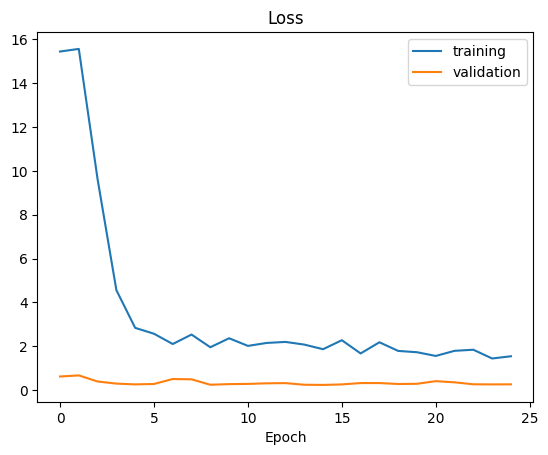

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Epoch 1/50
4/4 [==============================] - 7s 2s/step - loss: 1.5925 - accuracy: 0.2338 - val_loss: 0.2358 - val_accuracy: 0.4444
Epoch 2/50
4/4 [==============================] - 6s 2s/step - loss: 1.6190 - accuracy: 0.2407 - val_loss: 0.2329 - val_accuracy: 0.4444
Epoch 3/50
4/4 [==============================] - 6s 2s/step - loss: 1.7585 - accuracy: 0.2292 - val_loss: 0.2408 - val_accuracy: 0.4444
Epoch 4/50
4/4 [==============================] - 6s 2s/step - loss: 1.5022 - accuracy: 0.2407 - val_loss: 0.2537 - val_accuracy: 0.4444
Epoch 5/50
4/4 [==============================] - 6s 1s/step - loss: 1.4463 - accuracy: 0.2546 - val_loss: 0.2514 - val_accuracy: 0.4444
Epoch 6/50
4/4 [==============================] - 7s 2s/step - loss: 1.4726 - accuracy: 0.2616 - val_loss: 0.2443 - val_accuracy: 0.4444
Epoch 7/50
4/4 [==============================] - 6s 2s/step - loss: 1.3946 - accuracy: 0.2778 - val_loss: 0.2422 - val_accuracy: 0.4444
Epoch 7: early stopping


Text(0.5, 0, 'Epoch')

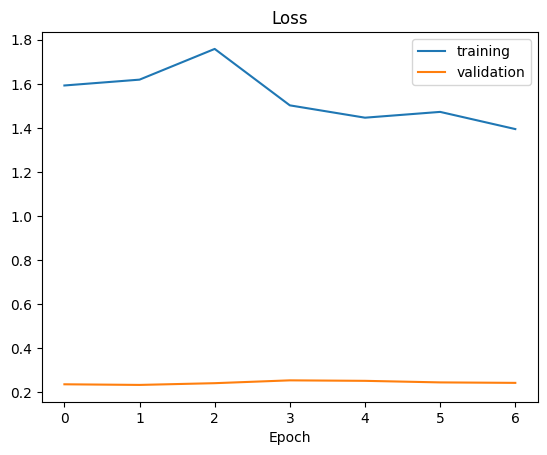

In [21]:
#model2 with early stopping and without batch normalization

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history2 = model.fit(X_train, Y_train, epochs=50, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1, callbacks=[early_stopping])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Epoch 1/50
4/4 [==============================] - 8s 2s/step - loss: 10.0321 - accuracy: 0.2569 - val_loss: 3.1170 - val_accuracy: 0.4444
Epoch 2/50
4/4 [==============================] - 6s 2s/step - loss: 7.8502 - accuracy: 0.2986 - val_loss: 1.2435 - val_accuracy: 0.4444
Epoch 3/50
4/4 [==============================] - 6s 2s/step - loss: 6.9322 - accuracy: 0.2963 - val_loss: 1.0991 - val_accuracy: 0.4444
Epoch 4/50
4/4 [==============================] - 6s 2s/step - loss: 4.0565 - accuracy: 0.3056 - val_loss: 1.0656 - val_accuracy: 0.4444
Epoch 5/50
4/4 [==============================] - 6s 2s/step - loss: 3.3703 - accuracy: 0.2731 - val_loss: 1.0540 - val_accuracy: 0.4444
Epoch 6/50
4/4 [==============================] - 6s 2s/step - loss: 2.5519 - accuracy: 0.2940 - val_loss: 0.8692 - val_accuracy: 0.4444
Epoch 7/50
4/4 [==============================] - 6s 2s/step - loss: 2.1810 - accuracy: 0.2824 - val_loss: 0.4544 - val_accuracy: 0.4444
Epoch 8/50
4/4 [========================

Text(0.5, 0, 'Epoch')

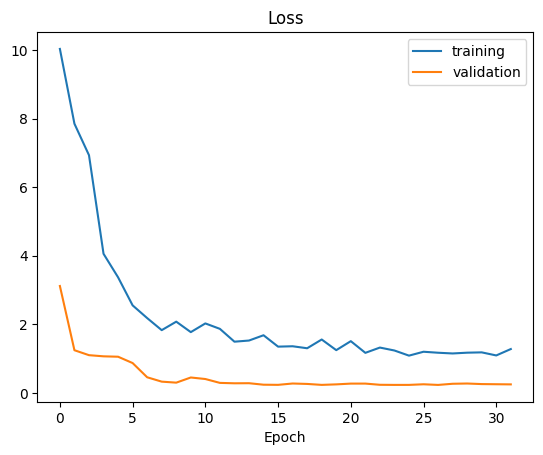

In [24]:
#model3 with early stopping and batch normalization

model3 = nvidia_model(bn=True)

history3 = model.fit(X_train, Y_train, epochs=50, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1, callbacks=[early_stopping])

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

As we can see, the model3 is performing the best among all the models